# TP2 - Linear Regression
___

##### File naming

In [11]:
fn1 = "bourhan"
ln1 = "dernayka"
filename = "_".join(map(lambda s: s.strip().lower(), ["SD-TSIA204_lab2", ln1, fn1])) + ".ipynb"
print(filename)

sd-tsia204_lab2_dernayka_bourhan.ipynb


___
### 1- Process the data

In [142]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1, style="whitegrid")

In [2]:
data = pd.read_csv("data_tp_2.csv", usecols= all)
data.head()

,X76,X95,X52,X36,X74,X69,X23,X27,X19,X39,...,X45,X67,X16,X37,X56,X35,X87,X89,X96,Y
0,-0.208298,0.793446,-0.200865,-0.005766,-0.336092,0.037238,0.148319,-1.423624,-0.411594,0.541975,...,-0.216825,0.552672,0.499400,0.134669,-1.639742,-0.004640,-0.635006,-0.758949,0.488324,24.0
1,-0.221028,-0.363311,-0.631604,1.152664,-0.532182,1.176513,-0.100142,1.170051,0.360931,0.593115,...,0.571930,-0.186832,-0.238081,1.404931,0.489104,0.248675,0.361039,0.435418,-1.324025,21.6
2,-1.059124,-0.777557,-0.172609,0.767116,0.141027,0.677921,0.820292,-0.255193,0.691621,0.254366,...,-0.643929,-0.543850,-0.478493,-0.386637,0.175114,-0.658092,-0.338583,-0.177981,-0.050339,34.7
3,1.133450,-0.790638,-0.586627,0.942378,0.283674,-0.577118,-0.145977,-0.263209,1.435926,-0.750034,...,0.719154,0.056236,-0.495367,0.204324,-1.078683,0.640999,-0.921276,-0.602238,0.421393,33.4
4,0.908181,-0.913293,0.362265,-0.437131,0.514517,-1.625222,1.019997,-0.422887,0.140903,-0.073760,...,1.026587,-0.230706,0.151710,-0.638937,0.072631,-0.517829,-1.028707,0.465484,0.351005,36.2


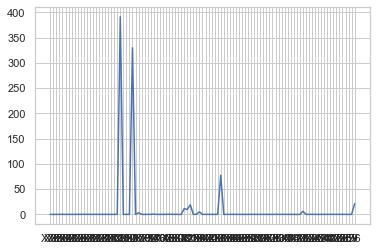

In [5]:
plot = plt.plot(data.median())

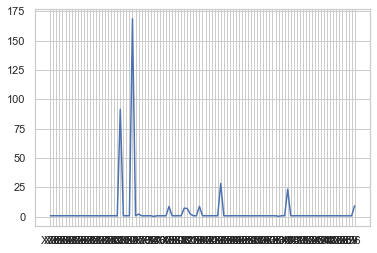

In [6]:
plot = plt.plot(data.std())

In [9]:
sum(data.median()<1), sum(data.std()<1)

(91, 90)

    We note that most of the data is close to being centered, 91 covariates out of 100 have a mean lesser than 1.
    Also, 90 covariates have standard deviations of less than 1.
    Hence, The data is not centered, normalized nor standardized (centered + normalized).

In [168]:
X = data.iloc[:,:-1]
X_matrix = X.to_numpy()
y = data.iloc[:,-1]
y_matrix = y.to_numpy()
n, p = X_matrix.shape

    We split the data into train and test sets, one fourth of the data is for testing.
    
    Note: removing the random_state parameter will generate different data partition on each run. However I opted to keep the same data partition throughout this study.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 7)

    We standarize our data using the StandardScaler() method fit_transform

In [5]:
X_train_matrix_fitted = StandardScaler().fit_transform(X_train)
X_test_matrix_fitted  = StandardScaler().fit_transform(X_test)

    In fact this is equivalent to doing it by hand: (small error difference comparing to the fit_transform method)

In [6]:
X_train_fitted = (X_train- np.mean(X_train))/np.std(X_train)
X_test_fitted  = (X_test - np.mean(X_test)) /np.std(X_test)  

In [7]:
sum(sum(np.array(X_train_fitted-X_train_matrix_fitted)))

1.1972297177080538e-11

We prove that this is indeed a negligible error.

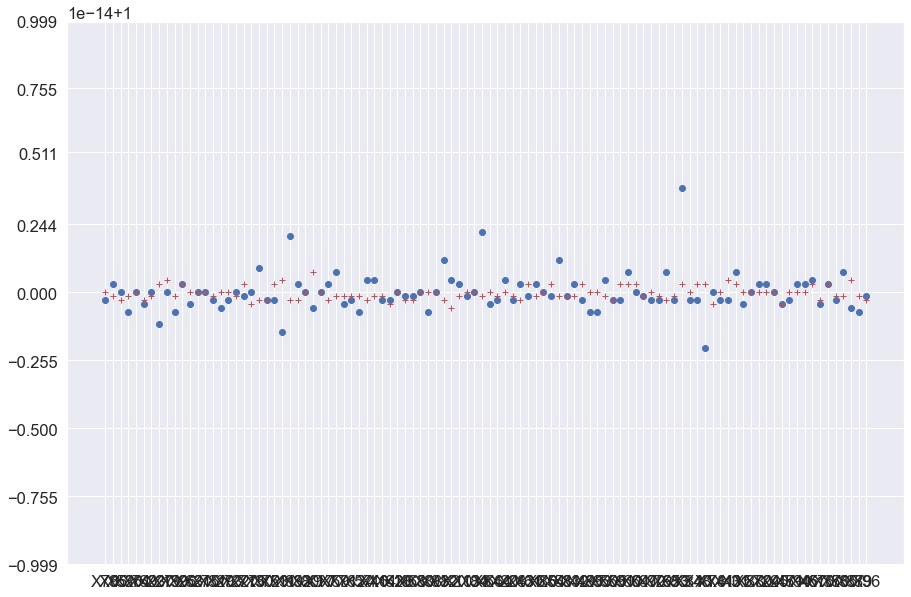

In [133]:
plt.figure(figsize=(15,10))
plt.ylim((1 - 1e-14, 1 + 1e-14))
#plt.yscale('log')
plot = plt.plot(X_train_fitted.columns, np.std(X_train_fitted), 'bo', X_test_fitted.columns, np.std(X_test_fitted), 'r+')

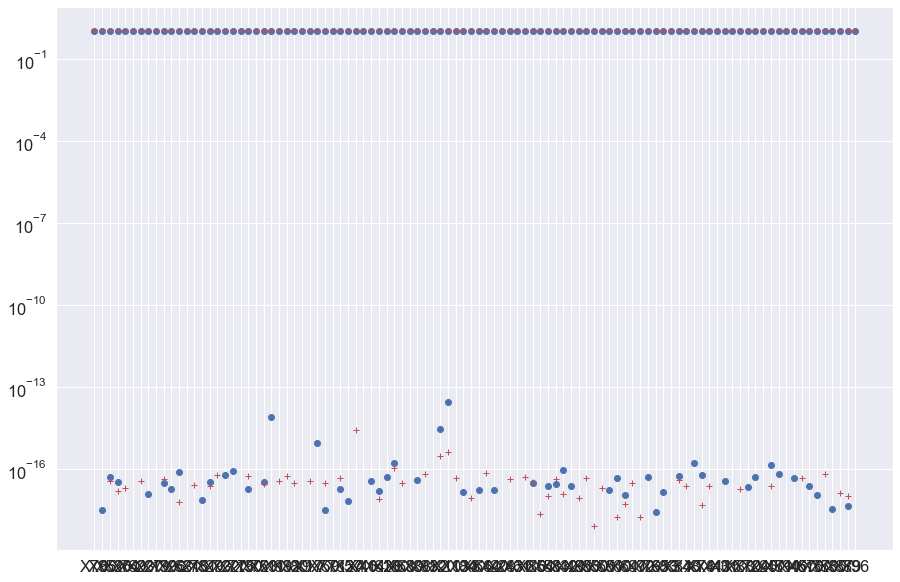

In [134]:
plt.figure(figsize=(15,10))
#plt.ylim((0 - 5e-14, 0 + 5e-14))
plt.yscale('log')
plot = plt.plot(X_train_fitted.columns, X_train_fitted.mean(), 'bo', 
                X_test_fitted.columns, X_test_fitted.mean(), 'r+')
plot = plt.plot(X_train_fitted.columns, X_train_fitted.std(), 'bo', 
                X_test_fitted.columns, X_test_fitted.std(), 'r+')

    We note that after standardizing the data, the mean is equal to 0 and the standard deviation equals 1 both to the order of 1e-14.
    
    Standardizing data is very important in the procedure of comparing different covariates that vary in range, amplitude or change rate. 
    In fact, it makes them all based on the same scale in order to have a meaningful covariation when comparing them together. In addition, this improves the LASSO method in particular, since it requires the presence of small, centered covariates in order to yield better answers.
    Actually, when computing the lambda parameters of the LASSO, their amplitudes depend on the amplitude of the variables they are multiplying. 
    Hence, smaller variables improve the minimization that the LASSO method tries to achieve.

In [22]:
df_test = pd.DataFrame()
df_coef = pd.DataFrame()

___
### 2- Functions to compute the determination coefficient and the mean squared error.

In [20]:
def det_coef(y, y_pred):
    """
        params: y is the actual output value vector
                y_pred is the prediction output of our model
        return: the determination coefficient of our model if dimensions match, -1 otherwise 
    """
    if y.shape != y_pred.shape:
        return -1
    y_mean = y.mean()
    return np.sum(np.power(y_pred - y_mean, 2)) / np.sum(np.power(y - y_mean, 2))
    # another implementation will be :
    #     return 1-np.sum(np.power(y_train - y_pred, 2)) / np.sum(np.power(y_train - y_train.mean(), 2))

    
def MSE(y, y_pred):
    """
        params: y is the actual output value vector
                y_pred is the prediction output of our model
        return: the Mean Squarred Error of our model if dimensions match, -1 otherwise 
    """
    if y.shape != y_pred.shape:
        return -1
    n = y.shape[0]
    return np.sum(np.power(y - y_pred, 2))/n

___
### 3- Fit a linear regression model on the train set.

In [154]:
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train_matrix_fitted, y_train)

print('Using "sklearn"\'s "linear_model" one obtains:\n')
#print('Estimated parameters are:')
#for i in range(100):
#    print('b{} = {:.4f},'.format(i, lin_reg.coef_[i]))

print('\nDetermination coefficient R^2 = {:.4f}.\n'.format(lin_reg.score(X_train_matrix_fitted, y_train)))

y_pred = lin_reg.predict(X_train_matrix_fitted)
#print(y_pred)
print(det_coef(y_train, y_pred))
1 - np.sum(np.power(y_train - y_pred, 2)) / np.sum(np.power(y_train - y_train.mean(), 2)), MSE(y_train, y_pred)

Using "sklearn"'s "linear_model" one obtains:


Determination coefficient R^2 = 0.8252.

0.8251762292000219


(0.8251762292000203, 15.182947739416157)

In [155]:
y_pred = lin_reg.predict(X_test_matrix_fitted)
det_coef(y_test, y_pred), MSE(y_test, y_pred)

(0.9237791977348628, 34.564509972465856)

506 100

Determination coefficient R^2 = 0.8228.

0.8228093268334308
14.506939679841077


0.8228093268334307

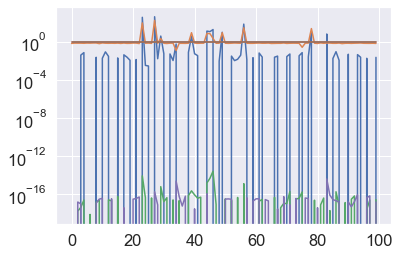

In [273]:
df = pd.read_csv('data_tp_2.csv')
Y = df.Y
df = df.drop('Y',axis=1)
X = df.values
n,p = X.shape
print(n,p)

plt.plot(X.mean(axis=0))
plt.plot(X.std(axis=0))
plt.yscale('log')

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25)
df_test = pd.DataFrame()
df_coef = pd.DataFrame()
results = []

X_train = StandardScaler().fit_transform(X_train)
plt.plot(X_train.mean(axis=0))
plt.plot(X_train.std(axis=0))

X_test = StandardScaler().fit_transform(X_test)
plt.plot(X_test.mean(axis=0))
plt.plot(X_test.std(axis=0))

lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train, y_train)
print('\nDetermination coefficient R^2 = {:.4f}.\n'.format(lin_reg.score(X_train, y_train)))
y_pred = lin_reg.predict(X_train)
print(det_coef(y_train, y_pred))
print(MSE(y_train, y_pred))
1-np.sum(np.power(y_train - y_pred, 2)) / np.sum(np.power(y_train - y_train.mean(), 2))


___
### 4- Covariation. SVD decomposition.

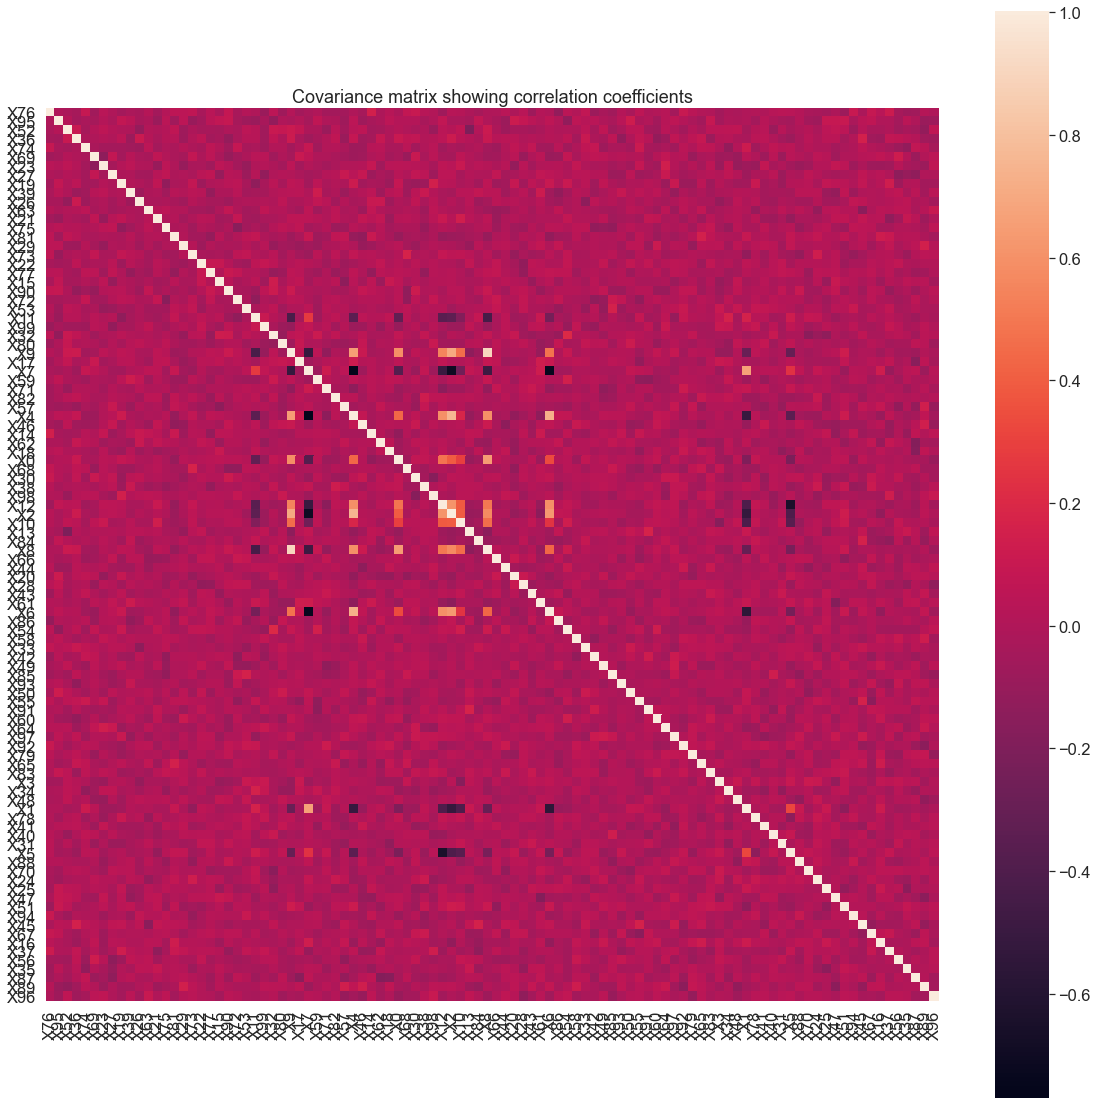

In [8]:
cov_mat = np.cov(X_train_fitted.T)
plt.figure(figsize=(20,20))
sns.set(font_scale=1.5)
hm = sns.heatmap(cov_mat,
                 cbar=True,
                 annot=False,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 12},
                 yticklabels = X_train_fitted.columns,
                 xticklabels= X_train_fitted.columns)
plt.title('Covariance matrix showing correlation coefficients')
plt.show()

In [169]:
colsNb = X_train_fitted.columns
h = np.cov(X_train_fitted.T)
covs = dict()
for i in range(100):
    for j in range(i):
        if h[i][j] > 0.5 and i != j:
            covs[(colsNb[i], colsNb[j])] = h[i][j]
covs

{('X4', 'X9'): 0.6514180155800358,
 ('X0', 'X9'): 0.5928933369726502,
 ('X12', 'X9'): 0.5468238557644425,
 ('X12', 'X4'): 0.5977859403618956,
 ('X2', 'X9'): 0.7026554616124125,
 ('X2', 'X4'): 0.7571401774281986,
 ('X2', 'X12'): 0.6092939908828128,
 ('X8', 'X9'): 0.9026062894473432,
 ('X8', 'X4'): 0.596055685342709,
 ('X8', 'X0'): 0.6437918187199472,
 ('X8', 'X2'): 0.5716140865700339,
 ('X6', 'X4'): 0.7260426041237691,
 ('X6', 'X12'): 0.6002642750260301,
 ('X6', 'X2'): 0.6352773100731111,
 ('X1', 'X7'): 0.6638118591706121}

    Here is the Singular Vaules Decomposition of the covariations matrix:

In [9]:
U, s, V = svd(cov_mat)

___
### 5- Primary Component Analysis

In [42]:
S = np.eye(U.shape[0])*s

In [11]:
sigma = np.zeros(X_train_fitted.shape)
sigma[:X_train_fitted.shape[1], :X_train_fitted.shape[1]] = np.diag(s)


In [235]:
from numpy.linalg import pinv
pinv(X_train_fitted).dot(X_train_fitted)

array([[ 1.00000000e+00, -2.82326246e-16,  6.93889390e-17, ...,
         1.61329283e-16,  1.63931368e-16, -9.02056208e-17],
       [-3.45209972e-16,  1.00000000e+00, -8.15320034e-17, ...,
         2.28983499e-16, -4.31078784e-16,  4.23272528e-16],
       [ 1.66533454e-16,  2.87964097e-16,  1.00000000e+00, ...,
         1.07552856e-16, -6.93889390e-18,  2.84494650e-16],
       ...,
       [ 6.24500451e-17,  2.42861287e-16,  3.60822483e-16, ...,
         1.00000000e+00,  5.04804532e-16, -8.32667268e-17],
       [ 2.42861287e-16, -8.32667268e-17, -2.11636264e-16, ...,
         3.43475248e-16,  1.00000000e+00,  9.02056208e-17],
       [-1.52655666e-16, -3.52148866e-16,  3.81639165e-16, ...,
        -1.70002901e-16,  1.38777878e-17,  1.00000000e+00]])

In [13]:
Us = U.dot(S)

In [14]:
US = Us[:,:2]

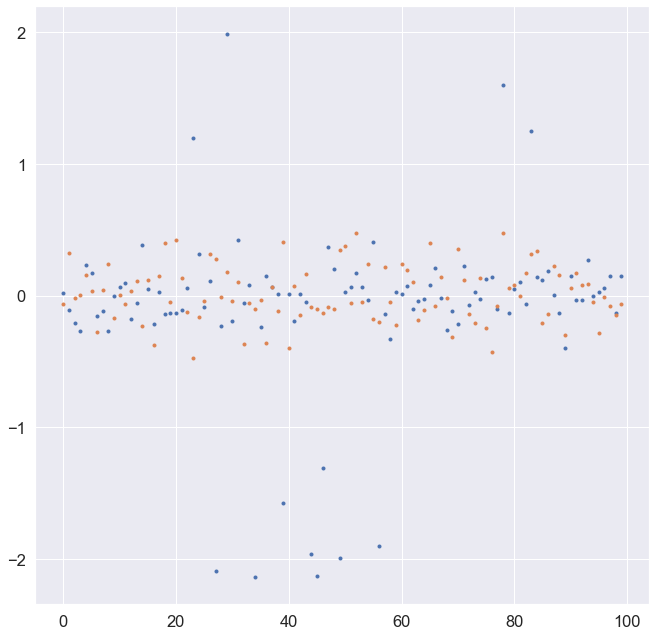

In [15]:
plt.figure(figsize=(11,11))
plot = plt.plot(US, '.')

In [16]:
PC1 = US[:,0]
PC2 = US[:,1]
np.mean(PC1), np.mean(PC2), np.std(PC1), np.std(PC2)

(-0.087248319487541,
 0.012442378838401023,
 0.6347860249998164,
 0.2144811247704796)

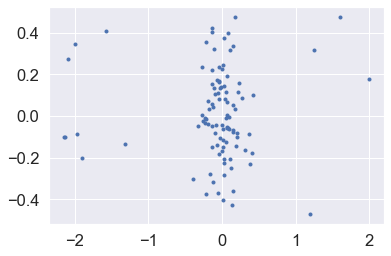

In [84]:
plt.plot(PC1, PC2, '.')

    We notice from the PC1-to-PC2 plot that almost all points go in a straight upwards line, meaning that the eigen value of the PC1 is much greater than that of PC2.

    By taking the 2d projection (covariation) of the selected components matrix, we notice indeed that lambda1 is ten times bigger than lambda2 (diagonal matrix)

In [95]:
US.T.dot(US)

array([[4.10565567e+01, 1.99840144e-15],
       [1.99840144e-15, 4.61569657e+00]])

___
### 6- PCA before OLS

In [117]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_train_fitted)
print(pca.components_.T, pca.explained_variance_)

[[-2.74853332e-03 -2.86252532e-02]
 [ 1.67226479e-02  1.49517604e-01]
 [ 3.29288580e-02 -7.37553517e-03]
 [ 4.26058827e-02  1.34276457e-03]
 [-3.60830629e-02  7.41036355e-02]
 [-2.67875559e-02  1.50072362e-02]
 [ 2.44603184e-02 -1.29049235e-01]
 [ 1.80013807e-02  1.94237321e-02]
 [ 4.25374600e-02  1.10459550e-01]
 [ 2.18520731e-04 -7.90711686e-02]
 [-1.04986581e-02  3.20122181e-03]
 [-1.51917831e-02 -2.98331573e-02]
 [ 2.81262642e-02  1.56510412e-02]
 [ 8.61364457e-03  5.07297612e-02]
 [-6.00541520e-02 -1.07759448e-01]
 [-8.29397271e-03  5.34066553e-02]
 [ 3.39605687e-02 -1.74378494e-01]
 [-4.06763317e-03  6.78646571e-02]
 [ 2.13869016e-02  1.87258805e-01]
 [ 2.03011990e-02 -2.20502613e-02]
 [ 2.10739642e-02  1.96136248e-01]
 [ 1.72971117e-02  6.16400877e-02]
 [-9.40540600e-03 -5.89070057e-02]
 [-1.86309214e-01 -2.19637468e-01]
 [-4.91028213e-02 -7.59363159e-02]
 [ 1.33445373e-02 -1.94013322e-02]
 [-1.69524704e-02  1.47607658e-01]
 [ 3.26368201e-01  1.27677701e-01]
 [ 3.56847203e-02 -3

In [17]:
X_PCA = X_train_fitted.dot(US)

In [18]:
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_PCA, y_train)


LinearRegression()

In [32]:
print('\nDetermination coefficient R^2 = {:.4f}.\n'.format(lin_reg.score(X_PCA, y_train)))

y_pred = lin_reg.predict(X_PCA)
det_coef(y_train, y_pred), MSE(y_train, y_pred)


Determination coefficient R^2 = 0.3968.



(0.3967849796910588, 52.38751050313448)

In [33]:
X_PCA.shape

(379, 2)

In [80]:
X_PCA_test = X_test_fitted.dot(US)
y_pred = lin_reg.predict(X_PCA_test)
det_coef(y_test, y_pred), MSE(y_test, y_pred)

(0.4250799136501633, 51.2936205212768)

In [79]:
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

,Actual,Predicted
357,21.7,17.093152
337,18.5,25.134312
327,22.2,24.600909
13,20.4,25.090731
418,8.8,10.218901
...,...,...
221,21.7,23.200432
98,43.8,28.137311
435,13.4,14.594477
40,34.9,31.242463


___
### 7- The loadings Phi

In [59]:
Uss = U.dot(np.sqrt(S))
Phi = np.abs(Us[:,:2])

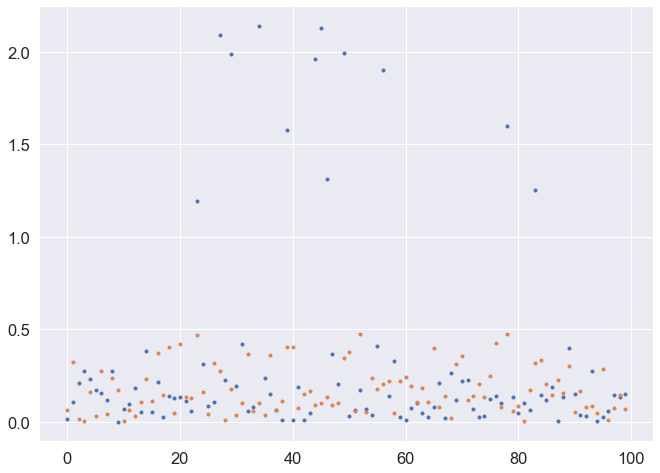

In [54]:
plt.figure(figsize=(11,8))
plot = plt.plot(USS, '.')

In [58]:
USS[:,0].mean(), USS[:,0].std(), USS[:,1].mean(), USS[:,1].std()

(0.326208452811098,
 0.5515012349061943,
 0.17337981413887057,
 0.12687161117893567)

___
### 8- LASSO

In [181]:
alpha = np.logspace(-3,1,30)
lasso_reg = LassoCV(alphas=alpha, n_alphas=30, verbose=True)
lasso_reg.fit(X_train_fitted, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
......................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


LassoCV(alphas=array([1.00000000e-03, 1.37382380e-03, 1.88739182e-03, 2.59294380e-03,
       3.56224789e-03, 4.89390092e-03, 6.72335754e-03, 9.23670857e-03,
       1.26896100e-02, 1.74332882e-02, 2.39502662e-02, 3.29034456e-02,
       4.52035366e-02, 6.21016942e-02, 8.53167852e-02, 1.17210230e-01,
       1.61026203e-01, 2.21221629e-01, 3.03919538e-01, 4.17531894e-01,
       5.73615251e-01, 7.88046282e-01, 1.08263673e+00, 1.48735211e+00,
       2.04335972e+00, 2.80721620e+00, 3.85662042e+00, 5.29831691e+00,
       7.27895384e+00, 1.00000000e+01]),
        n_alphas=30, verbose=True)

In [219]:
print(lasso_reg.score(X_train_fitted, y_train))
y_pred = lasso_reg.predict(X_test_fitted)
det_coef(y_test, y_pred), MSE(y_test, y_pred)

0.7590906758573308


(0.6719095894014863, 32.71028304813147)

In [220]:
print(lasso_reg.score(X_test_fitted, y_test))
print("The chosen aplpha by the LassoCrossValid algorithm was",lasso_reg.alpha_)
print("We have", sum(lasso_reg.coef_ != 0), "non-zero prediction coefficients, leaving us with", p - sum(lasso_reg.coef_ != 0), "sparse coefficients.")
#pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

0.5755388848684542
The chosen aplpha by the LassoCrossValid algorithm was 0.3039195382313198
We have 26 non-zero prediction coefficients, leaving us with 74 sparse coefficients.


___
### 9- Ridge

In [212]:
alpha = np.logspace(-1,2,30)
ridge_reg = RidgeCV(alphas=alpha)
ridge_reg.fit(X_train_fitted, y_train)

RidgeCV(alphas=array([  0.1       ,   0.1268961 ,   0.1610262 ,   0.20433597,
         0.25929438,   0.32903446,   0.41753189,   0.52983169,
         0.67233575,   0.85316785,   1.08263673,   1.3738238 ,
         1.74332882,   2.21221629,   2.8072162 ,   3.56224789,
         4.52035366,   5.73615251,   7.27895384,   9.23670857,
        11.72102298,  14.87352107,  18.87391822,  23.9502662 ,
        30.39195382,  38.56620421,  48.93900918,  62.10169419,
        78.80462816, 100.        ]))

In [216]:
print(ridge_reg.score(X_train_fitted, y_train))
y_pred = ridge_reg.predict(X_test_fitted)
det_coef(y_test, y_pred), MSE(y_test, y_pred)

0.8120894011909792


(0.7394988496219196, 33.307514025251976)

In [221]:
print(ridge_reg.score(X_test_fitted, y_test))
print("The chosen aplpha by the LassoCrossValid algorithm was", ridge_reg.alpha_)
print("We have", sum(ridge_reg.coef_ != 0), "non-zero prediction coefficients, leaving us with", p - sum(ridge_reg.coef_ != 0), "sparse coefficients.")
#pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

0.5677889878049938
The chosen aplpha by the LassoCrossValid algorithm was 48.93900918477494
We have 100 non-zero prediction coefficients, leaving us with 0 sparse coefficients.


___
### 10- Forward Variable Selection FVS

array([[ 1.00000000e+00, -2.54360420e-18,  1.78688355e-16, ...,
        -6.41847686e-17,  5.55111512e-17, -6.93889390e-18],
       [-2.54360420e-18,  1.00000000e+00,  3.51235257e-16, ...,
         6.24500451e-17,  6.24500451e-17, -3.81639165e-17],
       [ 1.78688355e-16,  3.51235257e-16,  1.00000000e+00, ...,
        -5.55111512e-17,  3.98986399e-17, -2.60208521e-17],
       ...,
       [-6.41847686e-17,  6.24500451e-17, -5.55111512e-17, ...,
         1.00000000e+00,  1.11224872e-15, -6.10622664e-16],
       [ 5.55111512e-17,  6.24500451e-17,  3.98986399e-17, ...,
         1.11224872e-15,  1.00000000e+00, -4.30211422e-16],
       [-6.93889390e-18, -3.81639165e-17, -2.60208521e-17, ...,
        -6.10622664e-16, -4.30211422e-16,  1.00000000e+00]])

___
### 11- FVS with stopping condition

___
### 12- OLS with FVS

___
### 13- Coefficients comparison